Temas:

Economia:
Estrutura a termo da taxa de juros, modelo de Vasicek, modelo de Nelson-Siegel dinâmico

Estatística:
Inferência bayesiana, modelos espaço de estados para séries temporais, previsão estatística (forecasting)

Ciência de dados:
Scraping, concatenação de tabelas, visualização de dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from scipy import stats
import quandl
from matplotlib import cm
from mpl_toolkits import mplot3d
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

A estrutura a termo das taxas de juros (ETTJ), ou curva de juros, é a relação entre as taxas de juros de títulos de renda fixa e suas respectivas maturidades. Normalmente costuma-se analisar a curva de juros de títulos da dívida soberana, que são considerados livres de risco de crédito e liquidez, por exemplo. 

A curva pode exibir três padrões principais, achatada (flat), íngreme (steep) ou invertida, com as maturidades mais curtas tendo taxas maiores. Segue um exemplo real destes três padrões na curva de títulos do governo dos EUA:

(0.01, 0.04)

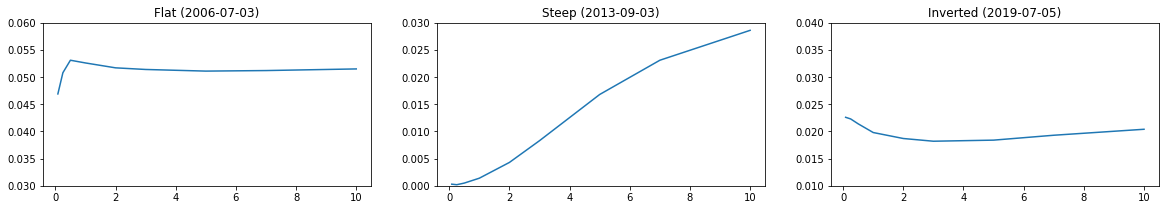

In [2]:
spot_us = quandl.get("USTREASURY/YIELD")/100
plt.figure(figsize=(20,3))
plt.subplot(1,3,1).set_title('Flat (2006-07-03)')
plt.plot([1/12,1/4,1/2,1,2,3,5,7,10],spot_us.loc[["2006-07-03"]].drop(['2 MO','20 YR','30 YR'],axis=1).values[0])
plt.ylim(0.03,0.06)
plt.subplot(1,3,2).set_title('Steep (2013-09-03)')
plt.plot([1/12,1/4,1/2,1,2,3,5,7,10],spot_us.loc[["2013-09-03"]].drop(['2 MO','20 YR','30 YR'],axis=1).values[0])
plt.ylim(0,0.03)
plt.subplot(1,3,3).set_title('Inverted (2019-07-05)')
plt.plot([1/12,1/4,1/2,1,2,3,5,7,10],spot_us.loc[["2019-07-05"]].drop(['2 MO','20 YR','30 YR'],axis=1).values[0])
plt.ylim(0.01,0.04)

Se pegarmos as taxas referentes a cada maturidade e olhar sua evolução ao longo do tempo, teremos um painel de séries temporais

Segue a curva de juros brasileira e americana ao longo do tempo

<AxesSubplot:title={'center':'ETTJ Brasil'}, xlabel='Date'>

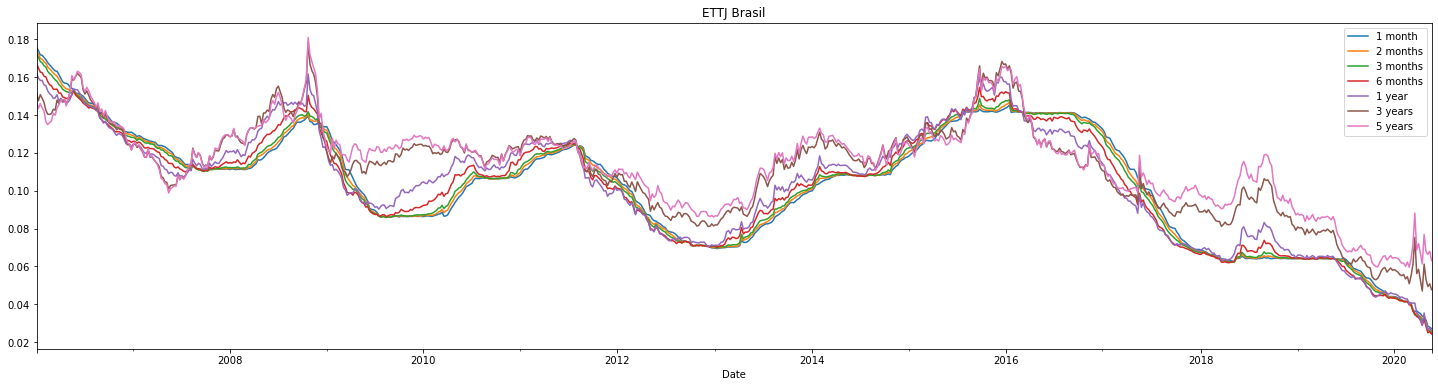

In [3]:
spot_br = pd.read_excel('http://nefin.com.br/resources/spot_rate_curve/spot_rate_curve.xls').set_index('Date')
spot_br['2006-01-01':].interpolate().asfreq("W",method='bfill').plot(title='ETTJ Brasil',figsize=(25,6))

<AxesSubplot:title={'center':'ETTJ EUA'}, xlabel='Date'>

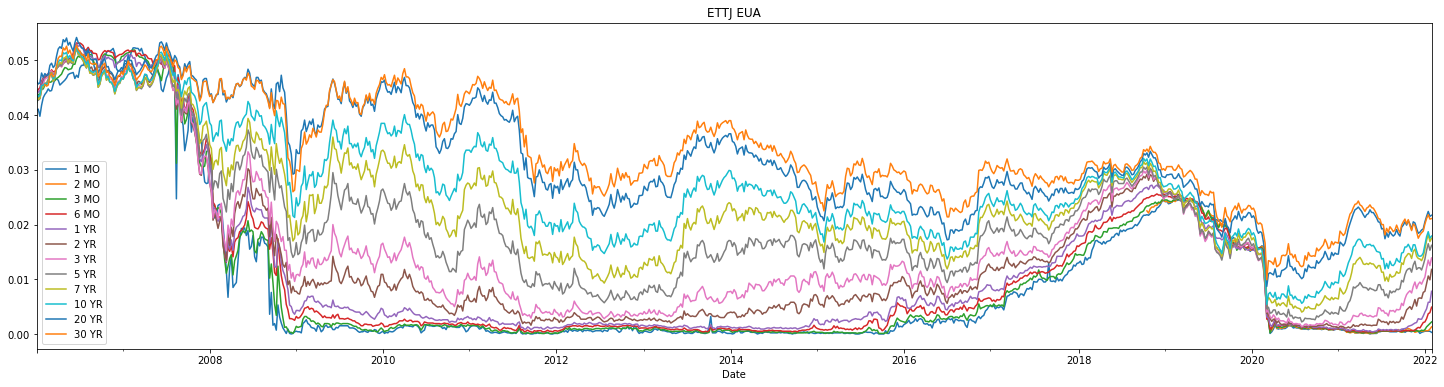

In [4]:
spot_us = quandl.get("USTREASURY/YIELD")/100
spot_us['2006-01-01':].interpolate().asfreq("W",method='bfill').plot(title='ETTJ EUA',figsize=(25,6))

O desafio é criar um modelo estatístico para estes dados. As primeiras abordagens sugeriram modelar todas as taxas como função de um único fator: a taxa de curto prazo, ou taxa short. A taxa short pode ser imaginada como uma taxa com maturidade "infinitamente curta", ou tendendo a zero. Na prática, esta variável não é observada no mundo real, e é comum utilizar taxas overnight ou de maturidade de um mês como aproximação.

Outra abordagem é tratar a taxa short como variável não observada, ou latente. Estatisticamente, podemos tratar a taxa short como variável de estado em um modelo de espaço de estados. Um exemplo de um modelo espaço de estados é o seguinte

$y_t = \mu + x_t + \varepsilon_t$

$x_t = \theta x_{t-1} + \eta_t$

$y_t$ é a nossa variável observada, $x_t$ a variável de estado ou latente, $\mu$ e $\theta$ são parâmetros e $\varepsilon_t$ e $\eta_t$ são choques aleatórios. A primeira equação é a equação de observação, e a segunda equação é a equação de estados.

Denotando $Y_t (\tau)$ como o nosso painel de taxas de juros observadas com maturidade $\tau$ e a taxa short como $r_t$, a nossa equação de observação para um modelo da curva de juros poderia ser o seguinte

$Y_t (\tau) = A(\tau) + B(\tau) r_t + \varepsilon_t$

Nos resta agora especificar a equação de estado. Qual processo a taxa short deveria seguir?

Houve tentativas de modelar $r_t$ como um movimento browniano geométrico (Rendleman e Bartter), o mesmo processo para o preço das ações no modelo Black-Scholes. No entanto, como a taxa de juros apresenta a propriedade empírica de reversão à média, este processo se mostra inadequado.

Vasicek (1977) propõe modelas a taxa short como

$dr_t = \kappa (\mu - r_t) dt + \sigma dW_t$

Isto é um processo de Ornstein-Uhlenbeck, a versão em tempo contínuo de um processo autorregressivo de ordem 1. Discretizando a equação, temos

$\Delta r_t = \kappa(\mu - r_{t-1})\Delta t + \sigma \sqrt{\Delta t} \varepsilon_t$

$r_{t+1} - r_t = \kappa(\mu - r_t})\Delta t + \sigma \sqrt{\Delta t} \varepsilon_t$

$r_{t+1} = r_t + \kappa(\mu - r_t)\Delta t + \sigma \sqrt{\Delta t} \varepsilon_t$

Os parâmetros do modelo são $\kappa$, $\mu$ e $\sigma$. $\Delta t$ irá depender da frequência dos nossos dados e da unidade de tempo adotada para as maturidades. Por exemplo, se estivermos medindo a maturidade em anos e tivermos dados de frequência semanal, nosso $\Delta t$ será igual a $\frac{1}{52}$. $\varepsilon_t$ segue uma distribuição normal padrão, isto é, com média 0 e variância 1.

O processo autorregressivo do modelo de Vasicek captura a propriedade de reversão à média das taxas de juros. O parâmetro $\mu$ pode ser interpretado como a média de longo prazo, $\kappa$ é a velocidade de reversão à média e $\sigma$ é a volatilidade, isto é, o desvio padrão dos choques aleatórios.

Segue alguns exemplos de simulação de processos de Vasicek para a taxa short, com diferentes valores para os parâmetros

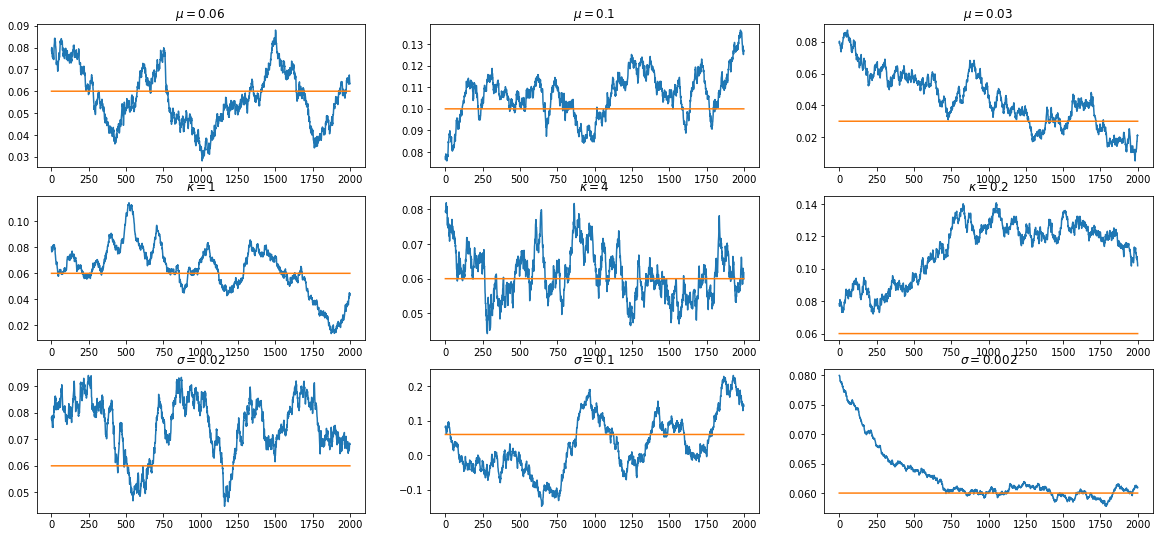

In [5]:
dt = 1/252

np.random.seed(123)
kappa_sim = 1
mu_sim = 0.06
sigma_sim = 0.02
r0_sim = 0.08
T = 2000
r_sim = np.empty(T)

plt.figure(figsize=(20,9))
plt.subplot(3,3,1).set_title(r'$\mu=0.06$')
mu_sim = 0.06
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")
plt.subplot(3,3,2).set_title(r'$\mu=0.1$')
mu_sim = 0.1
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")
plt.subplot(3,3,3).set_title(r'$\mu=0.03$')
mu_sim = 0.03
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")
plt.subplot(3,3,4).set_title(r'$\kappa=1$')
mu_sim = 0.06
kappa_sim = 1
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")
plt.subplot(3,3,5).set_title(r'$\kappa=4$')
kappa_sim = 4
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")
plt.subplot(3,3,6).set_title(r'$\kappa=0.2$')
kappa_sim = 0.2
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")
plt.subplot(3,3,7).set_title(r'$\sigma=0.02$')
kappa_sim = 1
sigma_sim = 0.02
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")
plt.subplot(3,3,8).set_title(r'$\sigma=0.1$')
sigma_sim = 0.1
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")
plt.subplot(3,3,9).set_title(r'$\sigma=0.002$')
sigma_sim = 0.002
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
plt.plot(r_sim, label=r"$r_t$")
plt.plot(np.repeat(mu_sim,len(r_sim)), label=r"$\mu$")

Como relacionamos a taxa short (variável de estado) com as taxas observadas no mercado para diferentes maturidades, isto é, construimos o nosso modelo de espaço de estados para a curva de juros?

Baseando-se na hipótese de não-arbitragem, as taxas observadas para cada maturidade $\tau$ serão da seguinte forma: $Y_t (\tau) = -\frac{A(\tau) - B(\tau)r_t}{\tau}$

As formas funcionais de $A(\tau)$ e $B(\tau)$ dependerão do processo seguido por $r_t$ (equação de estado)

No caso do nosso modelo: 

$B(\kappa,\tau) = \frac{1-\exp\{-\kappa \tau\}}{\kappa}$

$A(\kappa,\mu,\sigma,\tau) = \big(\frac{\sigma^2}{2\kappa^2} - \mu\big)\tau + \frac{1-\exp\{-\kappa \tau\}}{\kappa} \big(\mu - \frac{\sigma^2}{\kappa^2}\big) + \frac{\sigma^2}{4\kappa^3}(1-\exp\{-2\kappa \tau\})$

O processo da taxa short do modelo de Vasicek se dá em um mundo neutro ao risco, e para relacioná-los com as taxas observadas no mercado seria necessário a introdução de um parâmetro adicional, o preço de risco do mercado. No entanto, se substituirmos os parâmetros $\mu$ e $\kappa$ na equação de observação por novos parâmetros $a$ e $b$, não é necessário modelar o preço de risco do mercado explicitamente.

O nosso modelo de Vasicek na forma de espaço de estados será composto pelas seguintes equações

$Y_t (\tau) = -\frac{A(\tau) - B(\tau)r_t}{\tau} + \varepsilon_t$, $\varepsilon_t \sim N(0, \sigma_{obs})$

$dr_t = \kappa (\mu - r_t) dt + \sigma dW_t$

Adicionamos o erro de observação $\varepsilon_t$ na equação de observação

Os parâmetros $a$ e $b$ irão controlar como cada uma das taxas (séries) observadas se relacionam entre si. O parâmetro $a$, junto com a volatilidade da taxa short $\sigma^2$, irá afetar o nível das taxas de maturidades mais longas (lembrando que $Y_t (\tau \rightarrow 0) = r_t$). O parâmetro $b$ irá afetar o decaimento (distância) das taxas curtas em relação às longas, e também afeta o nível assim como o parâmetro $a$

Segue abaixo algumas simulações de dados para curva de juros no nosso modelo variando os valores dos parâmetros $a$ e $b$

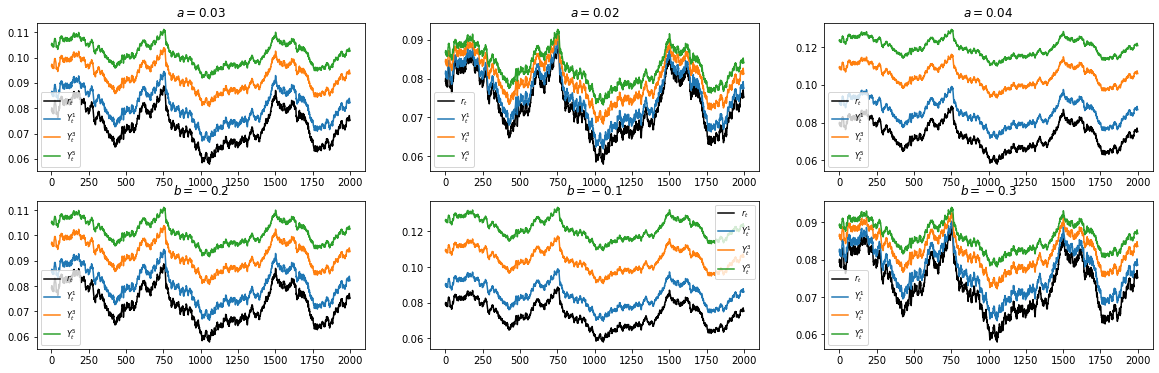

In [6]:
dt = 1/252

np.random.seed(123)
kappa_sim = 0.07
mu_sim = 0.1
sigma_sim = 0.01
r0_sim = 0.08
T = 2000

a_sim = 0.03
b_sim = -0.2

r_sim = np.zeros(T)
r_sim[0] = r0_sim + kappa_sim*(mu_sim - r0_sim)*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
for i in range(0, T - 1):
    r_sim[i + 1] = r_sim[i] + kappa_sim*(mu_sim - r_sim[i])*dt + (sigma_sim * np.sqrt(dt) * np.random.randn())
r_sim = r_sim.reshape((T,1))

def B(beta,tau):
    return (1 - np.exp(beta * tau))/beta

def alpha_coef(beta,tau):
    return (1/beta) * (((1 - np.exp(beta * tau))/beta) + tau)

def sigma2_coef(beta,tau):
    return 1/(2 * beta**2) * (((1 - np.exp(beta * tau))/beta) + (((1-np.exp(beta * tau))**2)/(2*beta)) + tau)

def A(beta,alpha,sigma,tau):
    return alpha*alpha_coef(beta,tau) + (sigma**2)*sigma2_coef(beta,tau)

TTM = np.array([1,3,5])
y_mean_sim = lambda tau: -(A(b_sim,a_sim,sigma_sim,tau) + B(b_sim,tau)*r_sim)/tau

plt.figure(figsize=(20,6))
plt.subplot(2,3,1).set_title(r'$a=0.03$')
Y_sim = y_mean_sim(TTM)
plt.plot(r_sim, label=r'$r_t$', color="black")
plt.plot(Y_sim[:,0], label=r'$Y^1_t$')
plt.plot(Y_sim[:,1], label=r'$Y^3_t$')
plt.plot(Y_sim[:,2], label=r'$Y^5_t$')
plt.legend(prop={'size': 8})
plt.subplot(2,3,2).set_title(r'$a=0.02$')
a_sim = 0.02
Y_sim = y_mean_sim(TTM)
plt.plot(r_sim, label=r'$r_t$', color="black")
plt.plot(Y_sim[:,0], label=r'$Y^1_t$')
plt.plot(Y_sim[:,1], label=r'$Y^3_t$')
plt.plot(Y_sim[:,2], label=r'$Y^5_t$')
plt.legend(prop={'size': 8})
plt.subplot(2,3,3).set_title(r'$a=0.04$')
a_sim = 0.04
Y_sim = y_mean_sim(TTM)
plt.plot(r_sim, label=r'$r_t$', color="black")
plt.plot(Y_sim[:,0], label=r'$Y^1_t$')
plt.plot(Y_sim[:,1], label=r'$Y^3_t$')
plt.plot(Y_sim[:,2], label=r'$Y^5_t$')
plt.legend(prop={'size': 8})
plt.subplot(2,3,4).set_title(r'$b=-0.2$')
a_sim = 0.03
Y_sim = y_mean_sim(TTM)
plt.plot(r_sim, label=r'$r_t$', color="black")
plt.plot(Y_sim[:,0], label=r'$Y^1_t$')
plt.plot(Y_sim[:,1], label=r'$Y^3_t$')
plt.plot(Y_sim[:,2], label=r'$Y^5_t$')
plt.legend(prop={'size': 8})
plt.subplot(2,3,5).set_title(r'$b=-0.1$')
b_sim = -0.1
Y_sim = y_mean_sim(TTM)
plt.plot(r_sim, label=r'$r_t$', color="black")
plt.plot(Y_sim[:,0], label=r'$Y^1_t$')
plt.plot(Y_sim[:,1], label=r'$Y^3_t$')
plt.plot(Y_sim[:,2], label=r'$Y^5_t$')
plt.legend(prop={'size': 8})
plt.subplot(2,3,6).set_title(r'$b=-0.3$')
b_sim = -0.3
Y_sim = y_mean_sim(TTM)
plt.plot(r_sim, label=r'$r_t$', color="black")
plt.plot(Y_sim[:,0], label=r'$Y^1_t$')
plt.plot(Y_sim[:,1], label=r'$Y^3_t$')
plt.plot(Y_sim[:,2], label=r'$Y^5_t$')
plt.legend(prop={'size': 8})

Iremos fazer inferência bayesiana para o modelo usando o PyMC3. Ele permite que a equação para $r_t$ seja especificada em tempo contínuo. Iremos usar as seguintes prioris para os parâmetros:

$\kappa \sim TN_{(0,\frac{2}{dt})} (0.7, 0.16)$

$\mu \sim TN_{(0,\infty)} (0.08, 0.01)$

$\sigma \sim HalfCauchy(0.03)$

$a \sim N(0.1, 0.01)$

$b \sim N(0.5, 0.25)$

$\sigma_{obs} \sim HalfCauchy(0.002)$

Onde $TN_{(x_1,x_2)} (\mu, \sigma^2)$ denota a distribuição normal truncada entre $x_1$ e $x_2$ com média $\mu$ e variância $\sigma^2$.

Estimando o modelo com dados do Brasil:

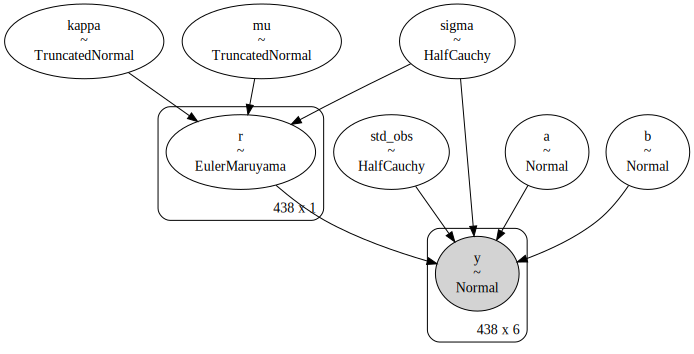

In [7]:
def vasicek_coeffs(x, kappa, mu, sigma):
    return kappa*(mu-x), sigma

def B(beta,tau):
    return (1 - pm.math.exp(-beta * tau))/beta

def A(beta,alpha,sigma,tau):
    return ((sigma**2/(2*pm.math.sqr(beta))) - alpha)*tau + (B(beta,tau)*(alpha - pm.math.sqr(sigma/beta))) + pm.math.sqr(sigma/(2*beta))*(1-pm.math.exp(-2*beta*tau))/beta

dt = 1/52

with pm.Model() as vasicek_br_model:

    kappa = pm.TruncatedNormal('kappa', mu = 0.7, sd = 0.4, lower=0, upper=2/dt)
    mu = pm.TruncatedNormal('mu', mu = 0.08, sd=0.1, lower=0)
    sigma = pm.HalfCauchy('sigma', beta = 0.03)
    a = pm.Normal('a', mu = 0.1, sd = 0.1)
    b = pm.Normal('b', mu = 0.5, sd = 0.5)
    
    T = len(spot_br['2012-01-01':"2021-01-01"].asfreq("W",method="bfill"))
    r = pm.distributions.timeseries.EulerMaruyama("r", dt, vasicek_coeffs, (kappa, mu, sigma,), shape=(T,1), testval=np.repeat(0.04,T).reshape((T,1)))

    y_mean = lambda tau: -(A(b,a,sigma,tau) - B(b,tau)*r)/tau
    TTM = np.array([1/6,1/4,1/2,1,3,5])

    std_obs = pm.HalfCauchy("std_obs", beta = 0.002)
    y = pm.Normal("y", mu=y_mean(TTM), sd=std_obs, shape=(T,len(TTM)), observed=spot_br['2012-01-01':"2021-01-01"].drop(['1 month'],axis=1).asfreq("W",method="bfill").values)
    
pm.model_to_graphviz(vasicek_br_model)

In [8]:
chains = 2
draws = 2000

with vasicek_br_model:
    vasicek_br_trace = pm.sample(draws, tune=1000, init='advi+adapt_diag', target_accept=0.9, chains=chains, return_inferencedata=False, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 49400
Interrupted at 49,399 [24%]: Average Loss = 1.2938e+08
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std_obs, r, b, a, sigma, mu, kappa]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.


In [9]:
with vasicek_br_model:
    vasicek_br_ppc = pm.sample_posterior_predictive(trace=vasicek_br_trace, keep_size=True)
    vasicek_br_data = az.from_pymc3(trace=vasicek_br_trace,posterior_predictive=vasicek_br_ppc,model=vasicek_br_model)

In [10]:
az.summary(vasicek_br_data,var_names=['~r'], stat_funcs={"median":np.median})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,median
a,0.137,0.001,0.135,0.140,0.000,0.000,2607.0,2607.0,2608.0,2855.0,1.0,0.137
b,0.181,0.006,0.170,0.193,0.000,0.000,2299.0,2299.0,2303.0,3052.0,1.0,0.181
kappa,0.085,0.057,0.000,0.183,0.001,0.001,2679.0,2679.0,2170.0,1929.0,1.0,0.079
mu,0.047,0.040,0.000,0.112,0.001,0.001,2993.0,2993.0,2436.0,1611.0,1.0,0.038
sigma,0.012,0.001,0.010,0.013,0.000,0.000,1164.0,1164.0,1163.0,2259.0,1.0,0.012
std_obs,0.006,0.000,0.006,0.006,0.000,0.000,6248.0,6245.0,6266.0,2553.0,1.0,0.006


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'std_obs'}>,
        <AxesSubplot:title={'center':'std_obs'}>]], dtype=object)

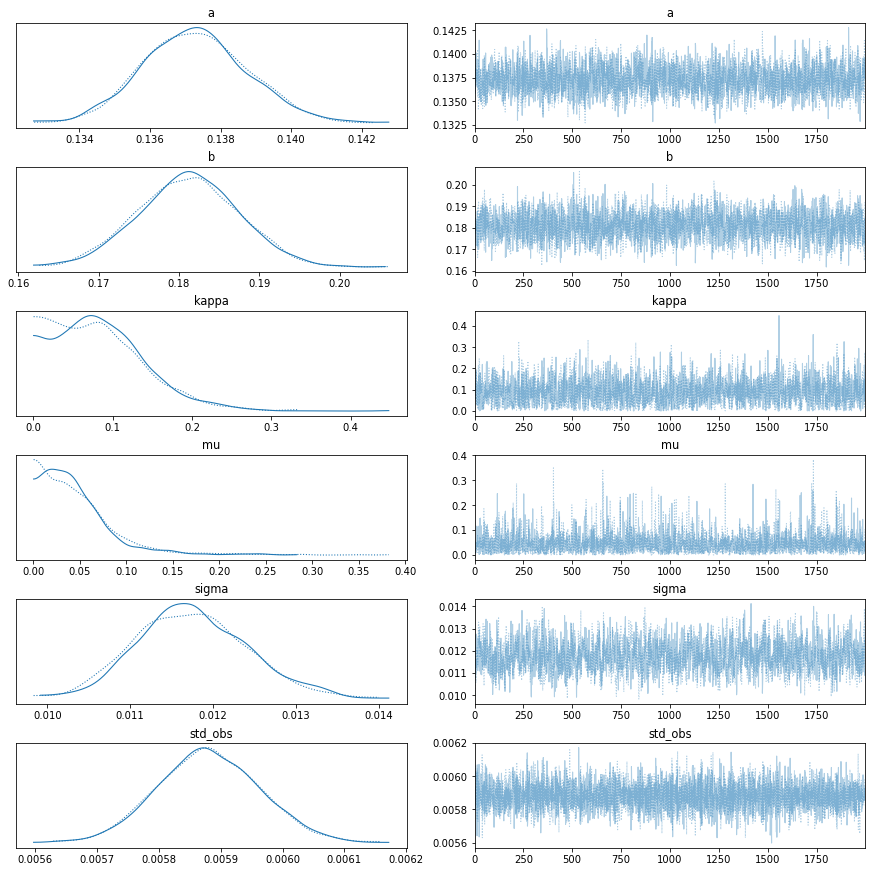

In [11]:
az.plot_trace(vasicek_br_data, var_names=['a','b','kappa','mu','sigma','std_obs'])

/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


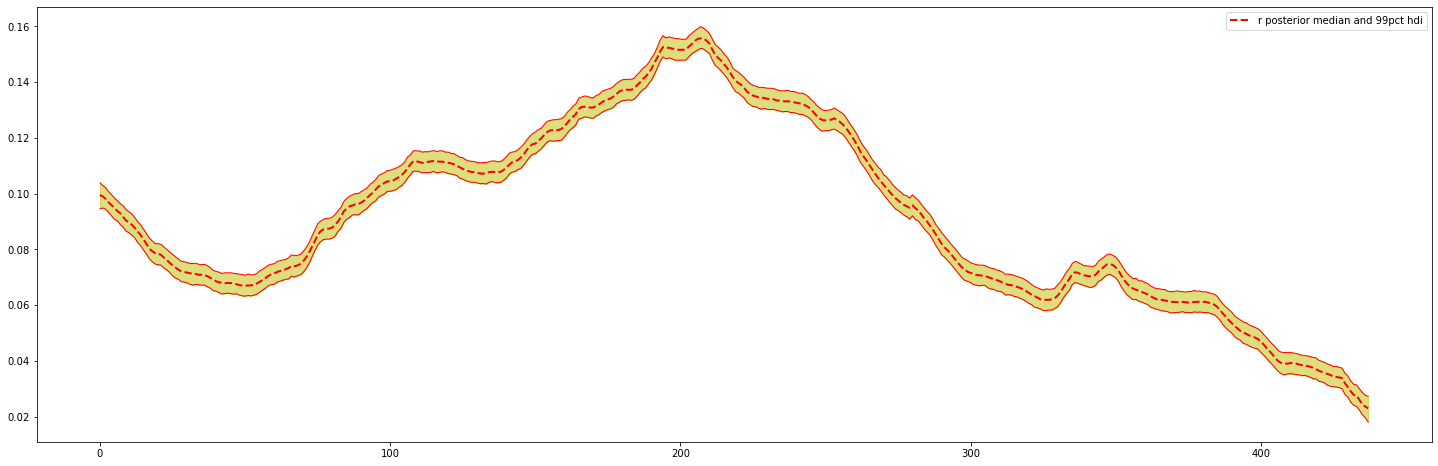

In [12]:
posterior_median = np.array(np.median(vasicek_br_trace[r],axis=0))

posterior_hpd_lower = az.hdi(vasicek_br_trace[r].T[0].T,hdi_prob=.99).T[0]

posterior_hpd_upper = az.hdi(vasicek_br_trace[r].T[0].T,hdi_prob=.99).T[1]

plt.figure(figsize=(25,8))
plt.plot(posterior_median, 'r', lw=2, label="r posterior median and 99pct hdi", linestyle='dashed')
plt.plot(posterior_hpd_upper, "r", lw=1)
plt.plot(posterior_hpd_lower, "r", lw=1)
plt.fill_between(range(0,T),posterior_hpd_lower, posterior_hpd_upper, color="y", alpha=0.5)
plt.legend()

Acima temos a estimativa do modelo para a taxa short do período, com a mediana a posteriori e intervalos de credibilidade.

Podemos construir visualizar as previsões do modelo de Vasicek para a curva de juros em 3D, e também o preço de uma call em função do preço de exercício

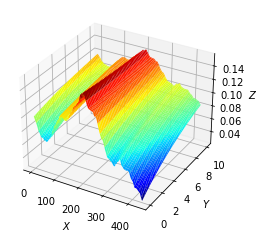

In [13]:
posterior_median_vasicek = np.array(np.median(vasicek_br_trace[r],axis=0).T)
b_median = np.median(vasicek_br_trace[b])
a_median = np.median(vasicek_br_trace[a])
sigma_median = np.median(vasicek_br_trace[sigma])

def B_median(beta,tau):
    return (1 - np.exp(-beta * tau))/beta

def A_median(beta,alpha,sig,tau):
    return ((sig**2/(2*beta**2)) - alpha)*tau + (B_median(beta,tau)*(alpha - (sig/beta)**2)) + ((sig/(2*beta))**2)*(1-np.exp(-2*beta*tau))/beta

def Y_median(tau,short,beta,alpha,sig):
    return (-(A_median(beta,alpha,sig,tau) - B_median(beta,tau)*short)/tau)

tau_range = np.linspace(0,10,100)
t_range = np.linspace(1,438,438)
t_range, tau_range = np.meshgrid(t_range,tau_range)

ax = plt.axes(projection='3d')
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")
ax.plot_surface(t_range, tau_range, Y_median(np.linspace(0.1,10,100),posterior_median_vasicek.T,b_median,a_median,sigma_median).T,cmap='jet')

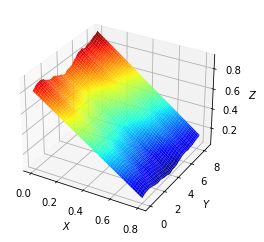

In [14]:
r_median = np.array(np.median(vasicek_br_trace[r],axis=0).T)[0]
b_median = np.median(vasicek_br_trace[b])
a_median = np.median(vasicek_br_trace[a])
sigma_median = np.median(vasicek_br_trace[sigma])

def B_opt(beta,t,T):
    return (1 - np.exp(-beta * (T-t)))/beta

def A_opt(beta,alpha,sig,t,T):
    return ((sig**2/(2*beta**2)) - alpha)*(T-t) + (B_opt(beta,t,T)*(alpha - (sig/beta)**2)) + ((sig/(2*beta))**2)*(1-np.exp(-2*beta*(T-t)))/beta

def P_opt(beta,alpha,sig,short,t,T):
    return np.exp(A_opt(beta,alpha,sig,t,T) - B_opt(beta,t,T)*short[(t/dt).astype(int)])

def sigma_p(beta,sig,t,V,T):
    return sig*B_opt(beta,V,T)*np.sqrt((1-np.exp(-2*beta*(V-t)))/2*beta)

def h_opt(beta,alpha,sig,short,t,V,T,X):
    return sigma_p(beta,sig,t,V,T)**-1 * np.log(P_opt(beta,alpha,sig,short,t,T)/(P_opt(beta,alpha,sig,short,t,V)*X)) + (sigma_p(beta,sig,t,V,T)/2)

def call_price(beta,alpha,sig,short,t,V,T,X):
    return P_opt(beta,alpha,sig,short,t,T)*stats.norm.cdf(h_opt(beta,alpha,sig,short,t,V,T,X)) - X*P_opt(beta,alpha,sig,short,t,V)*stats.norm.cdf(h_opt(beta,alpha,sig,short,t,V,T,X) - sigma_p(beta,sig,t,V,T))

X_range = np.linspace(0,0.8,100)
t_range = np.linspace(0,437*dt,438).reshape((438,1))
V_range = t_range + 1
T_range = t_range + 2
t_range, X_range = np.meshgrid(t_range,X_range)

ax = plt.axes(projection='3d')
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")
ax.plot_surface(X_range, t_range, call_price(b_median,a_median,sigma_median,r_median,np.linspace(0,437*dt,438).reshape((438,1)),np.linspace(0,437*dt,438).reshape((438,1))+1,np.linspace(0,437*dt,438).reshape((438,1))+2,np.linspace(0,0.8,100).T).T,cmap='jet')

Segundo o resultado clássico de Litterman e Scheinkman (1991), um único fator seria insuficiente para descrever a dinâmica da curva de juros. Três fatores seria o número ideal.

O modelo clássico de Nelson-Siegel faz uso de três fatores e consegue reproduzir bem todos os padrões observados para a curva de juros na prática. No entanto ele é um modelo estático, ajustando à curva de juros de um único período no tempo.

Diebold e Li (2006) introduzem dinâmica no modelo de Nelson-Siegel, criando o modelo de Nelson-Siegel dinâmico

$Y_t (\tau) = l_t + s_t \bigg(\frac{1-e^{-\lambda \tau}}{\lambda \tau}\bigg) + c_t \bigg(\frac{1-e^{-\lambda \tau}}{\lambda \tau} - e^{-\lambda \tau}\bigg)$

Aqui as três variáveis de estado, ou fatores, têm uma interpretabilidade empírica direta: $l_t$ corresponde ao nível da curva de juros (afeta taxas curtas e longas igualmente), $s_t$ à inclinação (afeta apenas taxas curtas) e $c_t$ à curvatura (afeta mais as taxas médias). Os coeficientes que multiplicam $l_t$, $s_t$ e $c_t$ são os factor loadings

Assumimos que cada um dos fatores ($l_t$, $s_t$ e $c_t$) segue um processo AR(1), similar ao de Vasicek. Aqui assumimos independência entre os processos por simplicidade, porém é comum tratar os processos como correlacionados

O parâmetro $\lambda$ controla os factor loadings, ou seja, a relação dos fatores com as taxas observadas.

Estimando o modelo Nelson-Siegel dinâmico com os dados do Brasil:

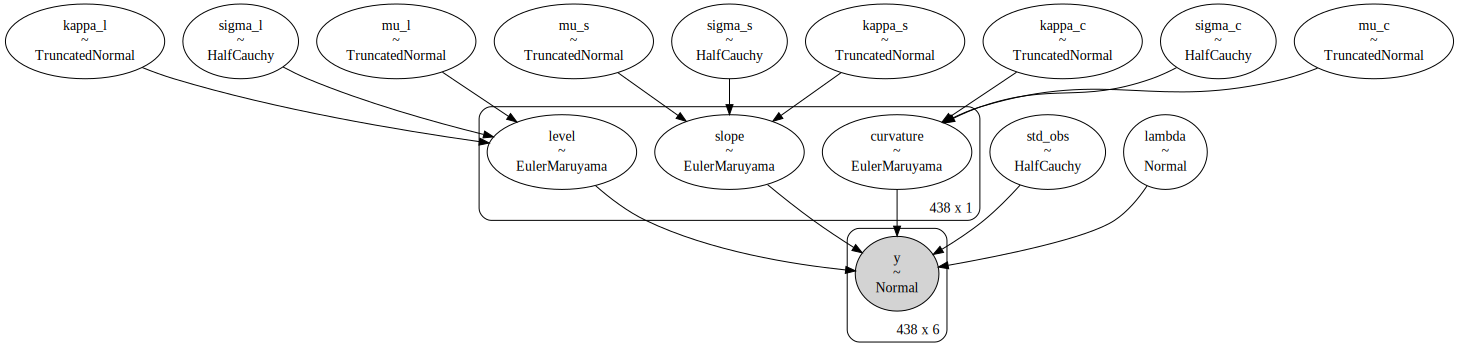

In [15]:
def ou_coeffs(x, kappa, mu, sigma):
    return kappa*(mu-x), sigma

dt = 1/52

with pm.Model() as dns_br_model:
    
    kappa_l = pm.TruncatedNormal('kappa_l', mu = 1, sd = 1, lower=0, upper=2/dt)
    mu_l = pm.TruncatedNormal('mu_l', mu = 0.12, sd=0.05, lower=-0.5)
    sigma_l = pm.HalfCauchy('sigma_l', beta = 0.015)
    kappa_s = pm.TruncatedNormal('kappa_s', mu = 0.8, sd = 0.5, lower=0, upper=2/dt)
    mu_s = pm.TruncatedNormal('mu_s', mu = -0.04, sd=0.03, upper=0.5)
    sigma_s = pm.HalfCauchy('sigma_s', beta = 0.015)
    kappa_c = pm.TruncatedNormal('kappa_c', mu = 0.5, sd = 0.4, lower=0, upper=2/dt)
    mu_c = pm.TruncatedNormal('mu_c', mu = -0.03, sd=0.04, upper=0.5)
    sigma_c = pm.HalfCauchy('sigma_c', beta = 0.015)
    
    lamb_ns = pm.Normal('lambda', mu = 1.1, sd = 0.3)

    T = len(spot_br['2012-01-01':"2021-01-01"].asfreq("W",method="bfill"))
    l = pm.distributions.timeseries.EulerMaruyama("level", dt, ou_coeffs, (kappa_l, mu_l, sigma_l,), shape=(T,1), testval=np.repeat(0.04,T).reshape((T,1)))
    s = pm.distributions.timeseries.EulerMaruyama("slope", dt, ou_coeffs, (kappa_s, mu_s, sigma_s,), shape=(T,1), testval=np.repeat(0.04,T).reshape((T,1)))
    c = pm.distributions.timeseries.EulerMaruyama("curvature", dt, ou_coeffs, (kappa_c, mu_c, sigma_c,), shape=(T,1), testval=np.repeat(0.04,T).reshape((T,1)))

    y_mean = lambda tau: l + s*((1-pm.math.exp(-lamb_ns*tau))/(lamb_ns*tau)) + c*(((1-pm.math.exp(-lamb_ns*tau))/(lamb_ns*tau)) - pm.math.exp(-lamb_ns*tau))
    TTM = np.array([1/6,1/4,1/2,1,3,5])

    std_obs = pm.HalfCauchy("std_obs", beta = 0.002)
    y = pm.Normal("y", mu=y_mean(TTM), sd=std_obs, shape=(T,len(TTM)), observed=spot_br['2012-01-01':"2021-01-01"].drop(['1 month'],axis=1).asfreq("W",method="bfill").values)
    
pm.model_to_graphviz(dns_br_model)

In [16]:
chains = 2
draws = 2000

with dns_br_model:
    dns_br_trace = pm.sample(draws, tune=1000, init='advi+adapt_diag', target_accept=0.95, chains=chains, return_inferencedata=False, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 79100
Interrupted at 79,099 [39%]: Average Loss = 5.5469e+07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std_obs, curvature, slope, level, lambda, sigma_c, mu_c, kappa_c, sigma_s, mu_s, kappa_s, sigma_l, mu_l, kappa_l]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 302 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [17]:
with dns_br_model:
    dns_br_ppc = pm.sample_posterior_predictive(trace=dns_br_trace, keep_size=True)
    dns_br_data = az.from_pymc3(trace=dns_br_trace,posterior_predictive=dns_br_ppc, model=dns_br_model)

In [18]:
az.summary(dns_br_data,var_names=['~level','~slope','~curvature'], stat_funcs={"median":np.median})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,median
lambda,1.395,0.013,1.371,1.420,0.001,0.000,431.0,431.0,431.0,857.0,1.0,1.394
kappa_l,0.589,0.362,0.000,1.203,0.010,0.007,1405.0,1405.0,1252.0,1606.0,1.0,0.549
mu_l,0.107,0.023,0.061,0.149,0.000,0.000,2223.0,2223.0,2175.0,1946.0,1.0,0.109
sigma_l,0.025,0.001,0.024,0.027,0.000,0.000,5880.0,5879.0,5884.0,3206.0,1.0,0.025
kappa_s,0.542,0.289,0.001,1.012,0.007,0.005,1840.0,1840.0,1575.0,1053.0,1.0,0.521
mu_s,-0.033,0.019,-0.072,0.001,0.000,0.000,4296.0,3047.0,4732.0,2265.0,1.0,-0.031
sigma_s,0.027,0.001,0.025,0.029,0.000,0.000,5901.0,5901.0,5863.0,3345.0,1.0,0.027
kappa_c,0.322,0.199,0.002,0.673,0.004,0.003,2522.0,2522.0,2202.0,2162.0,1.0,0.300
mu_c,-0.041,0.029,-0.100,0.012,0.000,0.000,5687.0,4624.0,5859.0,3017.0,1.0,-0.042
sigma_c,0.034,0.002,0.031,0.038,0.000,0.000,2212.0,2212.0,2213.0,3029.0,1.0,0.034


array([[<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>],
       [<AxesSubplot:title={'center':'kappa_l'}>,
        <AxesSubplot:title={'center':'kappa_l'}>],
       [<AxesSubplot:title={'center':'mu_l'}>,
        <AxesSubplot:title={'center':'mu_l'}>],
       [<AxesSubplot:title={'center':'sigma_l'}>,
        <AxesSubplot:title={'center':'sigma_l'}>],
       [<AxesSubplot:title={'center':'kappa_s'}>,
        <AxesSubplot:title={'center':'kappa_s'}>],
       [<AxesSubplot:title={'center':'mu_s'}>,
        <AxesSubplot:title={'center':'mu_s'}>],
       [<AxesSubplot:title={'center':'sigma_s'}>,
        <AxesSubplot:title={'center':'sigma_s'}>],
       [<AxesSubplot:title={'center':'kappa_c'}>,
        <AxesSubplot:title={'center':'kappa_c'}>],
       [<AxesSubplot:title={'center':'mu_c'}>,
        <AxesSubplot:title={'center':'mu_c'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>],
       [<A

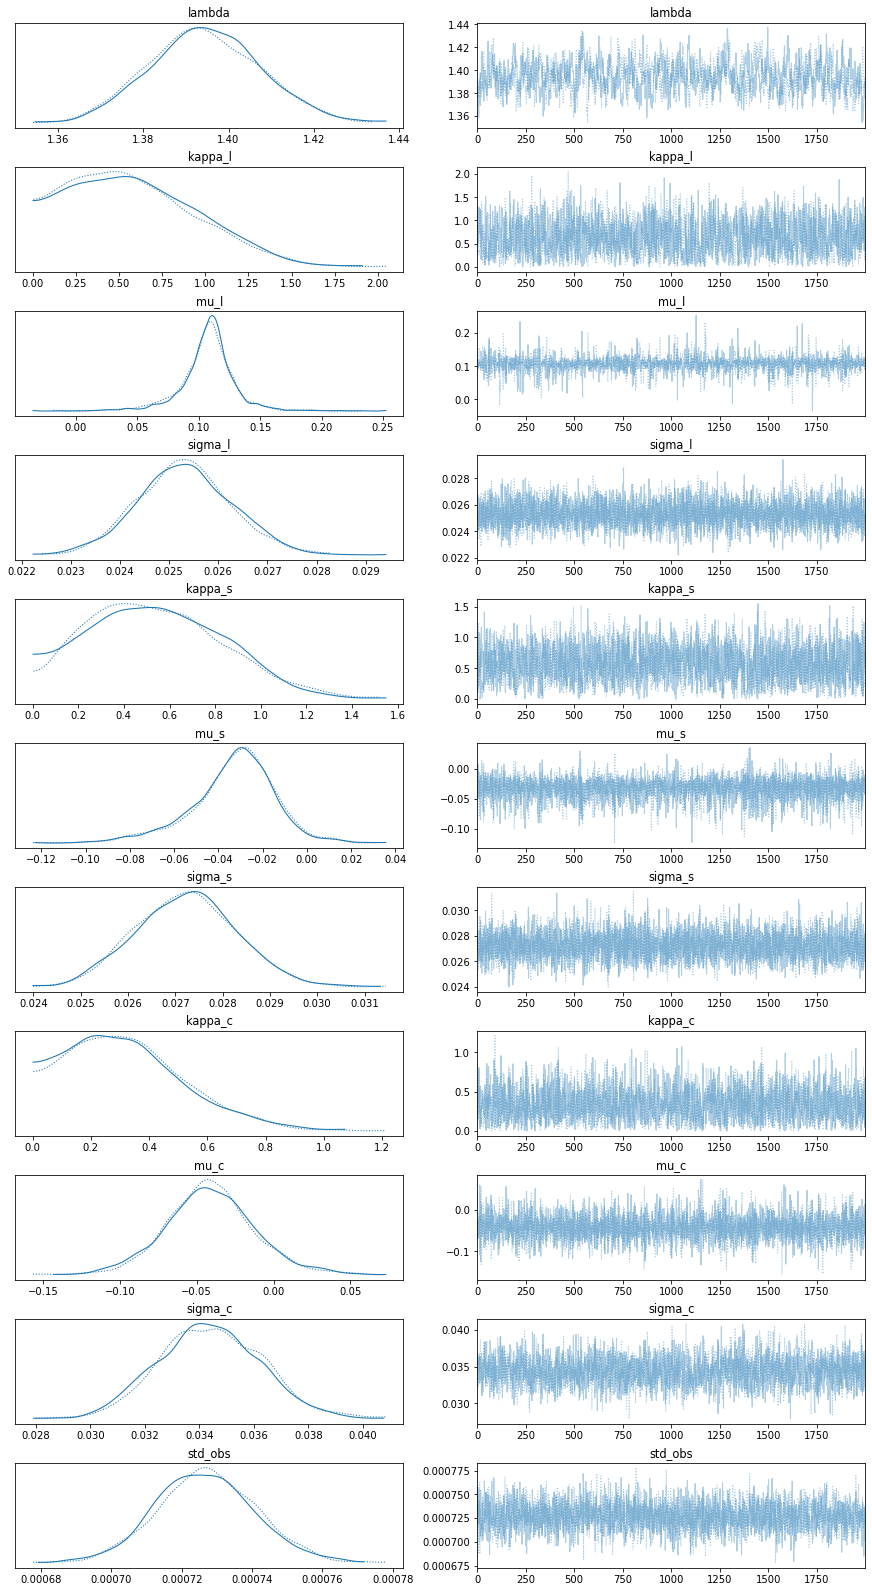

In [19]:
az.plot_trace(dns_br_data, var_names=['~level','~slope','~curvature'])

/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


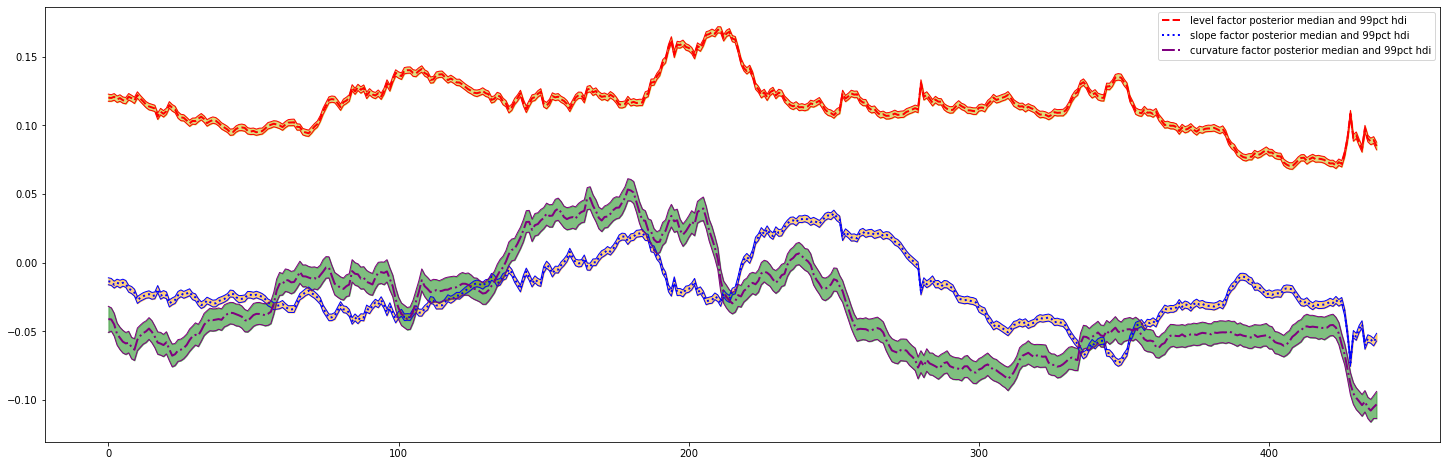

In [20]:
posterior_median_l = np.array(np.median(dns_br_trace[l],axis=0))
posterior_hpd_lower_l = az.hdi(dns_br_trace[l].T[0].T,hdi_prob=.99).T[0]
posterior_hpd_upper_l = az.hdi(dns_br_trace[l].T[0].T,hdi_prob=.99).T[1]
posterior_median_s = np.array(np.median(dns_br_trace[s],axis=0))
posterior_hpd_lower_s = az.hdi(dns_br_trace[s].T[0].T,hdi_prob=.99).T[0]
posterior_hpd_upper_s = az.hdi(dns_br_trace[s].T[0].T,hdi_prob=.99).T[1]
posterior_median_c = np.array(np.median(dns_br_trace[c],axis=0))
posterior_hpd_lower_c = az.hdi(dns_br_trace[c].T[0].T,hdi_prob=.99).T[0]
posterior_hpd_upper_c = az.hdi(dns_br_trace[c].T[0].T,hdi_prob=.99).T[1]

plt.figure(figsize=(25,8))
plt.plot(posterior_median_l, 'r', lw=2, label="level factor posterior median and 99pct hdi", linestyle='dashed')
plt.plot(posterior_hpd_upper_l, "r", lw=1)
plt.plot(posterior_hpd_lower_l, "r", lw=1)
plt.fill_between(range(0,T),posterior_hpd_lower_l, posterior_hpd_upper_l, color="y", alpha=0.5)
plt.plot(posterior_median_s, 'b', lw=2, label="slope factor posterior median and 99pct hdi", linestyle='dotted')
plt.plot(posterior_hpd_upper_s, "b", lw=1)
plt.plot(posterior_hpd_lower_s, "b", lw=1)
plt.fill_between(range(0,T),posterior_hpd_lower_s, posterior_hpd_upper_s, color="orange", alpha=0.5)
plt.plot(posterior_median_c, 'purple', lw=2, label="curvature factor posterior median and 99pct hdi", linestyle='dashdot')
plt.plot(posterior_hpd_upper_c, "purple", lw=1)
plt.plot(posterior_hpd_lower_c, "purple", lw=1)
plt.fill_between(range(0,T),posterior_hpd_lower_c, posterior_hpd_upper_c, color="g", alpha=0.5)
plt.legend()

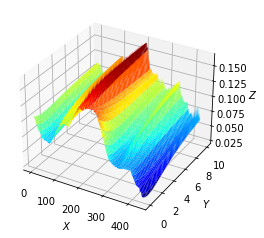

In [21]:
posterior_median_level = np.array(np.median(dns_br_trace[l],axis=0).T)
posterior_median_slope = np.array(np.median(dns_br_trace[s],axis=0).T)
posterior_median_curvature = np.array(np.median(dns_br_trace[c],axis=0).T)
lamb_ns = 0.7173

def Y_median(l,s,c,tau):
    return l + s*((1-np.exp(-lamb_ns*tau))/(lamb_ns*tau)) + c*(((1-np.exp(-lamb_ns*tau))/(lamb_ns*tau)) - np.exp(-lamb_ns*tau))

tau_range = np.linspace(0,10,100)
t_range = np.linspace(1,438,438)
t_range, tau_range = np.meshgrid(t_range,tau_range)

ax = plt.axes(projection='3d')
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")
ax.plot_surface(t_range, tau_range, Y_median(posterior_median_level.T,posterior_median_slope.T,posterior_median_curvature.T,np.linspace(0.1,10,100)).T,cmap='jet')

Vemos em 3 dimensões que o Nelson-Siegel dinâmico é capaz de reproduzir uma variedade maior de padrões para a curva de juros

Agora para avaliar e comparar as habilidades de previsão de ambos os modelos, vamos dividir a amostra em uma parte de "treino" e outra de teste e estimar os modelos assim

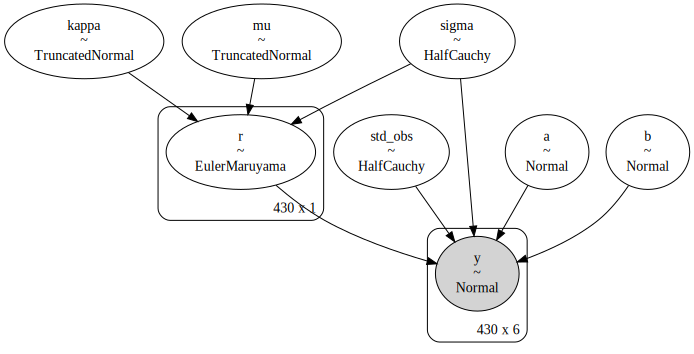

In [22]:
def vasicek_coeffs(x, kappa, mu, sigma):
    return kappa*(mu-x), sigma

def B(beta,tau):
    return (1 - pm.math.exp(-beta * tau))/beta

def A(beta,alpha,sigma,tau):
    return ((sigma**2/(2*pm.math.sqr(beta))) - alpha)*tau + (B(beta,tau)*(alpha - pm.math.sqr(sigma/beta))) + pm.math.sqr(sigma/(2*beta))*(1-pm.math.exp(-2*beta*tau))/beta

dt = 1/52
TTM = np.array([1/6,1/4,1/2,1,3,5])
dataset = spot_br['2012-01-01':"2021-01-01"].drop(['1 month'],axis=1).asfreq("W",method="bfill")

with pm.Model() as vasicek_br_model:

    kappa = pm.TruncatedNormal('kappa', mu = 0.7, sd = 0.4, lower=0, upper=2/dt)
    mu = pm.TruncatedNormal('mu', mu = 0.08, sd=0.1, lower=0)
    sigma = pm.HalfCauchy('sigma', beta = 0.03)
    a = pm.Normal('a', mu = 0.1, sd = 0.1)
    b = pm.Normal('b', mu = 0.5, sd = 0.5)

    T = len(dataset[0:430])
    r = pm.distributions.timeseries.EulerMaruyama("r", dt, vasicek_coeffs, (kappa, mu, sigma,), shape=(T,1), testval=np.repeat(0.04,T).reshape((T,1)))

    y_mean = lambda tau: -(A(b,a,sigma,tau) - B(b,tau)*r)/tau
    TTM = np.array([1/6,1/4,1/2,1,3,5])

    std_obs = pm.HalfCauchy("std_obs", beta = 0.002)
    y = pm.Normal("y", mu=y_mean(TTM), sd=std_obs, shape=(T,len(TTM)), observed=dataset.values[0:430])
    
pm.model_to_graphviz(vasicek_br_model)

In [23]:
chains = 1
draws = 2000

with vasicek_br_model:
    vasicek_br_trace = pm.sample(draws, tune=1000, init='advi+adapt_diag', target_accept=0.9, chains=chains, return_inferencedata=False, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 49600
Interrupted at 49,599 [24%]: Average Loss = 9.3491e+09
Sequential sampling (1 chains in 1 job)
NUTS: [std_obs, r, b, a, sigma, mu, kappa]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 52 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [24]:
with vasicek_br_model:
    vasicek_br_ppc = pm.sample_posterior_predictive(trace=vasicek_br_trace, keep_size=False)
    vasicek_br_data = az.from_pymc3(trace=vasicek_br_trace,posterior_predictive=vasicek_br_ppc,model=vasicek_br_model)

In [25]:
dataset = spot_br['2012-01-01':"2021-01-01"].drop(['1 month'],axis=1).asfreq("W",method="bfill")
forecast_sample = dataset[430:438]

def B_num(beta,tau):
    return (1 - np.exp(-beta * tau))/beta

def A_num(beta,alpha,sig,tau):
    return ((sig**2/(2*beta**2)) - alpha)*tau + (B_num(beta,tau)*(alpha - (sig/beta)**2)) + ((sig/(2*beta))**2)*(1-np.exp(-2*beta*tau))/beta

p_c_vas = np.empty([2000,8,len(TTM)])

observed = forecast_sample.values
r0 = 0.04

for i in range(0,2000):

    a_pred = vasicek_br_trace[a][i]
    b_pred = vasicek_br_trace[b][i]
    sigma_pred = vasicek_br_trace[sigma][i]
    kappa_pred = vasicek_br_trace[kappa][i]
    mu_pred = vasicek_br_trace[mu][i]
    sig_obs_pred = vasicek_br_trace[std_obs][i]

    r_pred = np.empty(8)
    r_pred[0] = vasicek_br_trace[r][i][-1] + kappa_pred*(mu_pred - vasicek_br_trace[r][i][-1])*dt + (np.random.randn() * np.sqrt(dt) * sigma_pred)
    for j in range(0,7):
        r_pred[j+1] = r_pred[j] + kappa_pred*(mu_pred - r_pred[j])*dt + (np.random.randn() * np.sqrt(dt) * sigma_pred)
    predicted_curve = -(A_num(b_pred,a_pred,sigma_pred,TTM) - B_num(b_pred,TTM)*r_pred.reshape((8,1)))/TTM + (np.random.randn() * sig_obs_pred)
    p_c_vas[i] = predicted_curve

p_c_vas = p_c_vas.T

abs_error_vas = np.empty(shape = (8,6))

for i in range(0,len(TTM)):
    for j in range(0,len(observed)):
        abs_error_vas[j][i] = np.sum(np.abs(p_c_vas[i][j] - observed[j][i]), axis=0)/draws

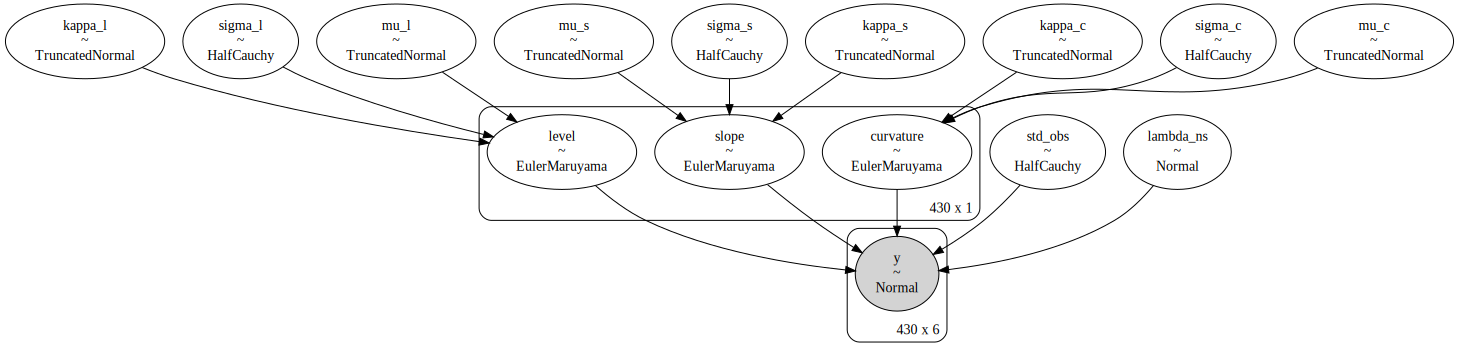

In [26]:
def ou_coeffs(x, kappa, mu, sigma):
    return kappa*(mu-x), sigma

dt = 1/52

with pm.Model() as dns_br_model:
    
    kappa_l = pm.TruncatedNormal('kappa_l', mu = 1, sd = 1, lower=0, upper=2/dt)
    mu_l = pm.TruncatedNormal('mu_l', mu = 0.12, sd=0.05, lower=-0.5)
    sigma_l = pm.HalfCauchy('sigma_l', beta = 0.015)
    kappa_s = pm.TruncatedNormal('kappa_s', mu = 0.8, sd = 0.5, lower=0, upper=2/dt)
    mu_s = pm.TruncatedNormal('mu_s', mu = -0.04, sd=0.03, upper=0.5)
    sigma_s = pm.HalfCauchy('sigma_s', beta = 0.015)
    kappa_c = pm.TruncatedNormal('kappa_c', mu = 0.5, sd = 0.4, lower=0, upper=2/dt)
    mu_c = pm.TruncatedNormal('mu_c', mu = -0.03, sd=0.04, upper=0.5)
    sigma_c = pm.HalfCauchy('sigma_c', beta = 0.015)
    
    lamb_ns = pm.Normal('lambda_ns', mu = 1.1, sd = 0.3)

    T = len(dataset[0:430])
    l = pm.distributions.timeseries.EulerMaruyama("level", dt, ou_coeffs, (kappa_l, mu_l, sigma_l,), shape=(T,1), testval=np.repeat(0.04,T).reshape((T,1)))
    s = pm.distributions.timeseries.EulerMaruyama("slope", dt, ou_coeffs, (kappa_s, mu_s, sigma_s,), shape=(T,1), testval=np.repeat(0.04,T).reshape((T,1)))
    c = pm.distributions.timeseries.EulerMaruyama("curvature", dt, ou_coeffs, (kappa_c, mu_c, sigma_c,), shape=(T,1), testval=np.repeat(0.04,T).reshape((T,1)))

    y_mean = lambda tau: l + s*((1-pm.math.exp(-lamb_ns*tau))/(lamb_ns*tau)) + c*(((1-pm.math.exp(-lamb_ns*tau))/(lamb_ns*tau)) - pm.math.exp(-lamb_ns*tau))
    TTM = np.array([1/6,1/4,1/2,1,3,5])

    std_obs = pm.HalfCauchy("std_obs", beta = 0.002)
    y = pm.Normal("y", mu=y_mean(TTM), sd=std_obs, shape=(T,len(TTM)), observed=dataset.values[0:430])
    
pm.model_to_graphviz(dns_br_model)

In [27]:
chains = 2
draws = 2000

with dns_br_model:
    dns_br_trace = pm.sample(draws, tune=1000, init='advi+adapt_diag', target_accept=0.95, chains=chains, return_inferencedata=False, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 72400
Interrupted at 72,399 [36%]: Average Loss = 3.5909e+07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std_obs, curvature, slope, level, lambda_ns, sigma_c, mu_c, kappa_c, sigma_s, mu_s, kappa_s, sigma_l, mu_l, kappa_l]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 316 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [28]:
with dns_br_model:
    dns_br_ppc = pm.sample_posterior_predictive(trace=dns_br_trace, keep_size=True)
    dns_br_data = az.from_pymc3(trace=dns_br_trace,posterior_predictive=dns_br_ppc, model=dns_br_model)

In [29]:
forecast_sample = dataset[430:438]

kappa_l_median = np.median(dns_br_trace[kappa_l])
mu_l_median = np.median(dns_br_trace[mu_l])
sigma_l_median = np.median(dns_br_trace[sigma_l])
kappa_s_median = np.median(dns_br_trace[kappa_s])
mu_s_median = np.median(dns_br_trace[mu_s])
sigma_s_median = np.median(dns_br_trace[sigma_s])
kappa_c_median = np.median(dns_br_trace[kappa_c])
mu_c_median = np.median(dns_br_trace[mu_c])
sigma_c_median = np.median(dns_br_trace[sigma_c])
lambda_median = np.median(dns_br_trace[lamb_ns])

In [30]:
forecast_sample = dataset[430:438]
p_c_dns = np.empty([2000,8,len(TTM)])
observed = forecast_sample.values
abs_error_dns = np.empty(shape = (8,6))

for i in range(0,2000):

    sigma_l_pred = dns_br_trace[sigma_l][i]
    kappa_l_pred = dns_br_trace[kappa_l][i]
    mu_l_pred = dns_br_trace[mu_l][i]
    sigma_s_pred = dns_br_trace[sigma_s][i]
    kappa_s_pred = dns_br_trace[kappa_s][i]
    mu_s_pred = dns_br_trace[mu_s][i]
    sigma_c_pred = dns_br_trace[sigma_c][i]
    kappa_c_pred = dns_br_trace[kappa_c][i]
    mu_c_pred = dns_br_trace[mu_c][i]
    lambda_pred = dns_br_trace[lamb_ns][i]
    sig_obs_pred = dns_br_trace[std_obs][i]

    l_pred = np.empty(8)
    l_pred[0] = dns_br_trace[l][i][-1] + kappa_l_pred*(mu_l_pred - dns_br_trace[l][i][-1])*dt + (np.random.randn() * np.sqrt(dt) * sigma_l_pred)
    s_pred = np.empty(8)
    s_pred[0] = dns_br_trace[s][i][-1] + kappa_s_pred*(mu_s_pred - dns_br_trace[s][i][-1])*dt + (np.random.randn() * np.sqrt(dt) * sigma_s_pred)
    c_pred = np.empty(8)
    c_pred[0] = dns_br_trace[c][i][-1] + kappa_c_pred*(mu_c_pred - dns_br_trace[c][i][-1])*dt + (np.random.randn() * np.sqrt(dt) * sigma_c_pred)
    for j in range(0,7):
        l_pred[j+1] = l_pred[j] + kappa_l_pred*(mu_l_pred - l_pred[j])*dt + (np.random.randn() * np.sqrt(dt) * sigma_l_pred)
        s_pred[j+1] = s_pred[j] + kappa_s_pred*(mu_s_pred - s_pred[j])*dt + (np.random.randn() * np.sqrt(dt) * sigma_s_pred)
        c_pred[j+1] = c_pred[j] + kappa_c_pred*(mu_c_pred - c_pred[j])*dt + (np.random.randn() * np.sqrt(dt) * sigma_c_pred)
    predicted_curve = l_pred.reshape((8,1)) + s_pred.reshape((8,1))*((1-np.exp(-lambda_median*TTM))/(lambda_median*TTM)) + c_pred.reshape((8,1))*(((1-np.exp(-lambda_median*TTM))/(lambda_median*TTM)) - np.exp(-lambda_median*TTM))
    p_c_dns[i] = predicted_curve

p_c_dns = p_c_dns.T

for i in range(0,len(TTM)):
    for j in range(0,len(observed)):
        abs_error_dns[j][i] = np.sum(np.abs(p_c_dns[i][j] - observed[j][i]), axis=0)/draws

Podemos visualizar na forma de gráfico as distribuições a posteriori das previsões para as taxas spot, separando por cada maturidade e horizonte de previsão (de 1 a 8 semanas)

A zona sombreada em azul é o intervalo de credibilidade de 90%, a linha preta é a mediana a posteriori e a linha vermelha os valores reais

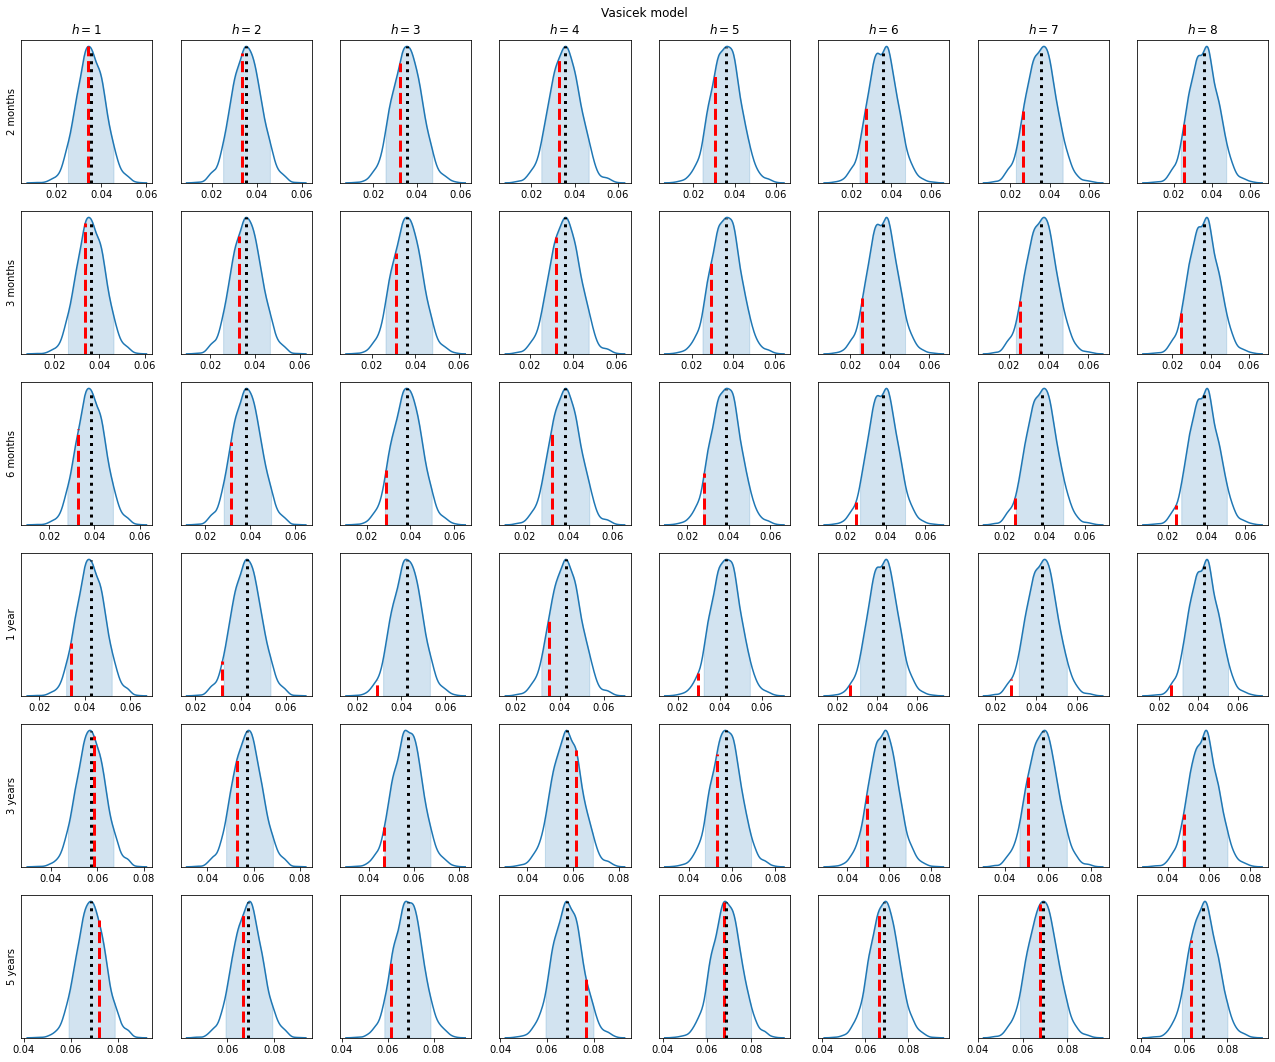

In [31]:
dataset = spot_br['2012-01-01':"2021-01-01"].drop(['1 month'],axis=1).asfreq("W",method="bfill")
TTM = np.array([1/6,1/4,1/2,1,3,5])
forecast_sample = dataset[430:438]
observed = forecast_sample.values
maturities = ["2 months", "3 months", "6 months", "1 year", "3 years", "5 years"]
# model_list = ["Vasicek","DNS"]
horizon = [r'$h = {}$'.format(h) for h in range(1, 9)]

fig = plt.figure(figsize=(18,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle("Vasicek model")
plot_no = 0
for i in range(0,len(TTM)):
    for j in range(0,len(forecast_sample)):
        plot_no += 1
        ax = fig.add_subplot(6, 8, plot_no)
        sns.kdeplot(p_c_vas[i][j], ax=ax)
        x_val = ax.lines[-1].get_xdata()
        y_val = ax.lines[-1].get_ydata()
        mask = ((x_val > az.hdi(p_c_vas[i][j],hdi_prob=.90)[0]) & (x_val < az.hdi(p_c_vas[i][j],hdi_prob=.90)[1]))
        plt.axvline(observed[j][i], 0, y_val[np.abs(x_val - observed[j][i]).argmin()]/ax.get_ybound()[1], color="red", linestyle="dashed", linewidth=3, label = r'$y_{obs} = $' + str(observed[j][i].round(4)))
        plt.axvline(np.median(p_c_vas[i][j]), 0, y_val[np.abs(x_val - np.median(p_c_vas[i][j])).argmin()]/ax.get_ybound()[1], color="black", linestyle="dotted", linewidth=3, label = r'$\hat{y}_{median} = $' + str(np.median(p_c_vas[i][j]).round(4)))
        plt.fill_between(x_val[mask], 0, y_val[mask], color=sns.color_palette()[0], alpha=0.2)
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(maturities[i])
        else:
            plt.ylabel("")
        if i == 0:
            plt.title(horizon[j])
fig.tight_layout()
fig.subplots_adjust(top=0.95)

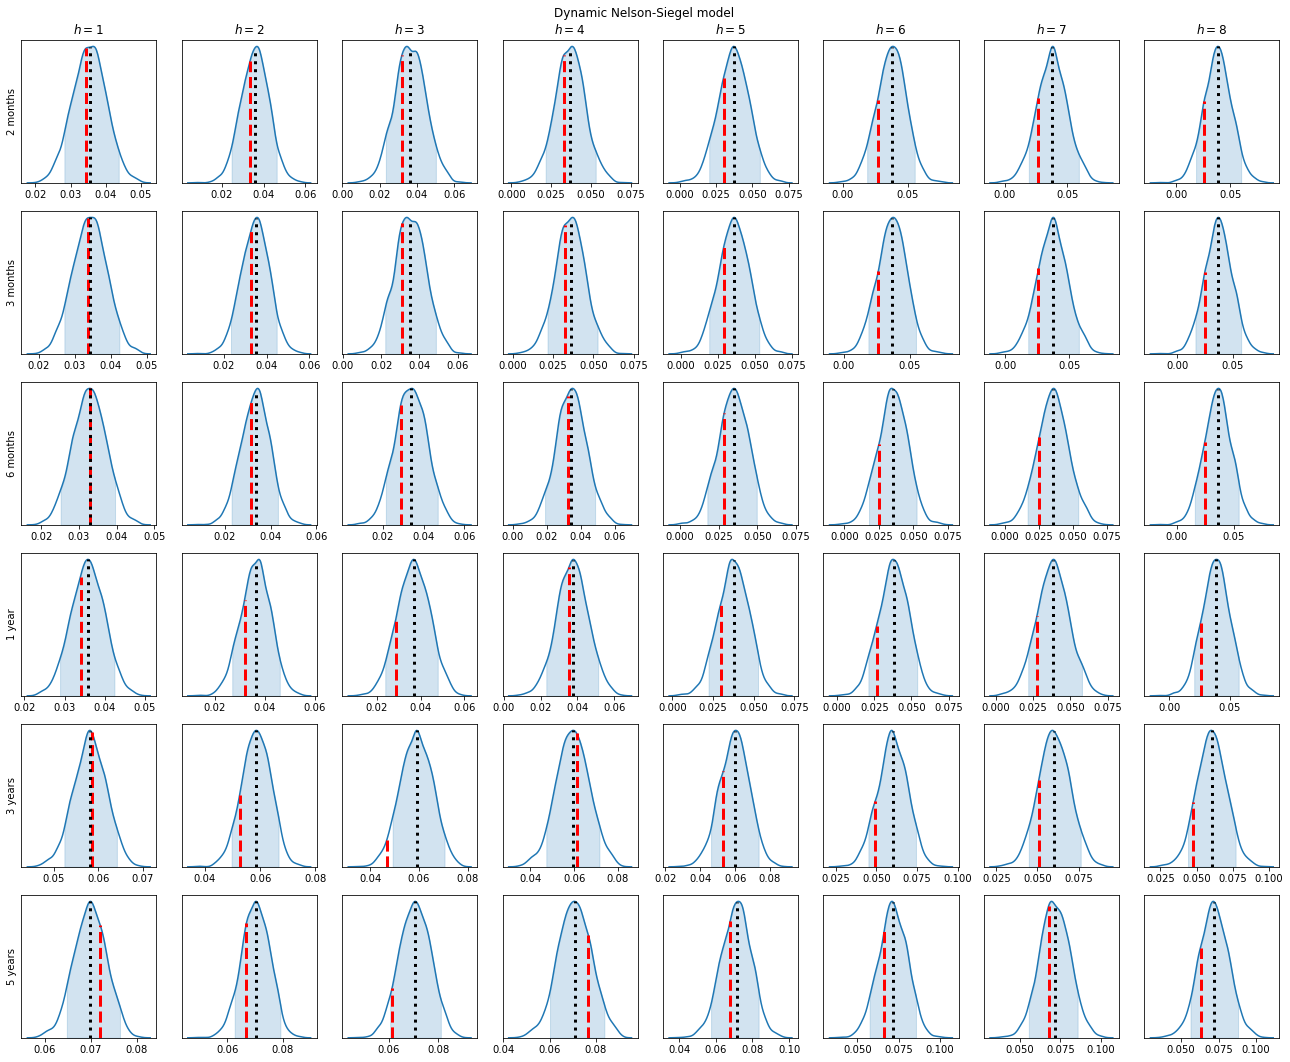

In [32]:
dataset = spot_br['2012-01-01':"2021-01-01"].drop(['1 month'],axis=1).asfreq("W",method="bfill")
TTM = np.array([1/6,1/4,1/2,1,3,5])
forecast_sample = dataset[430:438]
observed = forecast_sample.values
maturities = ["2 months", "3 months", "6 months", "1 year", "3 years", "5 years"]
# model_list = ["Vasicek","DNS"]
horizon = [r'$h = {}$'.format(h) for h in range(1, 9)]

fig = plt.figure(figsize=(18,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle("Dynamic Nelson-Siegel model")
plot_no = 0
for i in range(0,len(TTM)):
    for j in range(0,len(forecast_sample)):
        plot_no += 1
        ax = fig.add_subplot(6, 8, plot_no)
        sns.kdeplot(p_c_dns[i][j], ax=ax)
        x_val = ax.lines[-1].get_xdata()
        y_val = ax.lines[-1].get_ydata()
        mask = ((x_val > az.hdi(p_c_dns[i][j],hdi_prob=.90)[0]) & (x_val < az.hdi(p_c_dns[i][j],hdi_prob=.90)[1]))
        plt.axvline(observed[j][i], 0, y_val[np.abs(x_val - observed[j][i]).argmin()]/ax.get_ybound()[1], color="red", linestyle="dashed", linewidth=3, label = r'$y_{obs} = $' + str(observed[j][i].round(4)))
        plt.axvline(np.median(p_c_dns[i][j]), 0, y_val[np.abs(x_val - np.median(p_c_dns[i][j])).argmin()]/ax.get_ybound()[1], color="black", linestyle="dotted", linewidth=3, label = r'$\hat{y}_{median} = $' + str(np.median(p_c_dns[i][j]).round(4)))
        plt.fill_between(x_val[mask], 0, y_val[mask], color=sns.color_palette()[0], alpha=0.2)
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(maturities[i])
        else:
            plt.ylabel("")
        if i == 0:
            plt.title(horizon[j])
fig.tight_layout()
fig.subplots_adjust(top=0.95)

Também é possível usar medidas de erro de previsão, como o desvio médio absoluto

Vamos colocar o desvio médio absoluto da previsão em relação à obsevação para ambos os modelos, para cada horizonte e maturidade

In [33]:
horizon_list = [r'$h = {}$'.format(h) for h in range(1, 9)]

mae_vas = pd.DataFrame(abs_error_vas.round(4), index=horizon_list, columns = maturities).T
mae_dns = pd.DataFrame(abs_error_dns.round(4), index=horizon_list, columns = maturities).T
mae_table = pd.concat([mae_vas, mae_dns], keys=["Vasicek","DNS"])
df = mae_table.swaplevel(axis=0).sort_index().reindex(pd.MultiIndex.from_product([maturities,["Vasicek","DNS"]], names=['Maturity', 'Model']))
df

$h = 1$  $h = 2$  $h = 3$  $h = 4$  $h = 5$  $h = 6$  \
Maturity Model                                                           
2 months Vasicek   0.0050   0.0054   0.0061   0.0060   0.0072   0.0094   
         DNS       0.0039   0.0057   0.0075   0.0083   0.0103   0.0128   
3 months Vasicek   0.0054   0.0059   0.0069   0.0064   0.0082   0.0109   
         DNS       0.0038   0.0055   0.0073   0.0080   0.0100   0.0127   
6 months Vasicek   0.0067   0.0079   0.0100   0.0076   0.0107   0.0139   
         DNS       0.0036   0.0053   0.0075   0.0074   0.0096   0.0123   
1 year   Vasicek   0.0090   0.0111   0.0140   0.0083   0.0133   0.0164   
         DNS       0.0037   0.0061   0.0091   0.0070   0.0102   0.0129   
3 years  Vasicek   0.0050   0.0063   0.0106   0.0061   0.0063   0.0088   
         DNS       0.0029   0.0067   0.0122   0.0062   0.0087   0.0118   
5 years  Vasicek   0.0055   0.0051   0.0082   0.0087   0.0052   0.0056   
         DNS       0.0033   0.0050   0.0097   0.0076   0.0072   0.0082   

                  $h = 7$  $h = 8$  
Maturity Model                      
2 months Vasicek   0.0099   0.0108  
         DNS       0.0137   0.0151  
3 months Vasicek   0.0111   0.0121  
         DNS       0.0133   0.0147  
6 months Vasicek   0.0135   0.0145  
         DNS       0.0125   0.0139  
1 year   Vasicek   0.0154   0.0170  
         DNS       0.0127   0.0144  
3 years  Vasicek   0.0078   0.0102  
         DNS       0.0111   0.0138  
5 years  Vasicek   0.0053   0.0072  
         DNS       0.0080   0.0109